In [1]:
import os
import numpy as np
import pandas as pd
import re,random
import jieba
import pickle 
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from hyperopt import fmin, tpe, hp, space_eval, rand, Trials, partial, STATUS_OK
from hyperopt.pyll import scope
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
stop_list=[]
with open('./stopword.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        stop_list.append(line.strip())

In [3]:
def preprocess(data,all_data,category):
    for idx, line in enumerate(data):
        line = re.sub(r'[^\w]','',line)
        line = re.sub(r'[A-Za-z0-9]','',line)
        line = re.sub(u'[\uFF01-\uFF5A]','',line)
        line = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))','',line)
        segment_list = jieba.lcut(line)
        segment_list = filter(lambda x: len(x)>1,segment_list)
        segment_list = filter(lambda x: x not in stop_list,segment_list)
        all_data.append( (' '.join(segment_list),category[idx]) )
    return all_data

In [4]:
def load_data(filePath, fileName):
    pos = pd.read_csv(filePath + fileName + ".csv_P.csv")
    print("number of positive docs:%d" %len(pos))
    neg = pd.read_csv(filePath + fileName + ".csv_N.csv")
    print("number of negative docs:%d"%len(neg))
    pre_data = pd.concat([pos,neg],axis=0)
    data = []
    text = pd.DataFrame(columns=["text","label"])
    text["text"] = pre_data["title"].fillna("")+pre_data["content"].fillna("")
    text["label"] = pre_data["label"] 
    text= text.reset_index(drop=True)
    data =  preprocess(text["text"],data,text["label"])
    return data

In [5]:
filePath = "./"  
fileName = "鴻海"
data = load_data(filePath ,fileName)
random.shuffle(data)
x,y = zip(*data)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=666)

number of positive docs:7029


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\xiaoy\AppData\Local\Temp\jieba.cache


number of negative docs:7289


Loading model cost 0.638 seconds.
Prefix dict has been built successfully.


In [6]:
stocks = {}
stocks["台積電"]="tmx"
stocks["大立光"]="dlg"
stocks["鴻海"]="hh"

In [7]:
stockname = stocks[fileName]

In [8]:
tvec = TfidfVectorizer(
    analyzer='word',
    ngram_range=(2,6), 
    max_features=8000 
)
tvec.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=8000,
                min_df=1, ngram_range=(2, 6), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [9]:
# baseline decision tree
dt = tree.DecisionTreeClassifier() 
dt.fit(tvec.transform(x_train),y_train)
dt_pred = dt.predict(tvec.transform(x_test))
print ('Decision tree f1-score: %.4f' %metrics.f1_score(y_test,dt_pred))
print ('Decision tree accuracy: %.4f' %metrics. accuracy_score(y_test,dt_pred))

Decision tree f1-score: 0.5725
Decision tree accuracy: 0.5815


In [10]:
'''
# default
xgboost = XGBClassifier()
xgboost.fit(tvec.transform(x_train),y_train)
xgboost_pred = xgboost.predict(tvec.transform(x_test))
print ('Default xgboost f1-score: %.4f' %metrics.f1_score(y_test,xgboost_pred))
print ('Default xgboost accuracy: %.4f' %metrics. accuracy_score(y_test,xgboost_pred))
'''


"\n# default\nxgboost = XGBClassifier()\nxgboost.fit(tvec.transform(x_train),y_train)\nxgboost_pred = xgboost.predict(tvec.transform(x_test))\nprint ('Default xgboost f1-score: %.4f' %metrics.f1_score(y_test,xgboost_pred))\nprint ('Default xgboost accuracy: %.4f' %metrics. accuracy_score(y_test,xgboost_pred))\n"

In [11]:
# XGB parameters
xgb_clf_params = {
    'learning_rate':    hp.uniform('learning_rate', 0.001, 0.01),
    'max_depth':        scope.int(hp.quniform('max_depth', 5, 20, q=1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     scope.int(hp.quniform('n_estimators', 50, 300, q=1))
}
xgb_fit_params = {
    'eval_metric': 'logloss',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
xgb_para['clf_params'] = xgb_clf_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: log_loss(y, pred, eps=1e-15, normalize=True)

In [12]:
class XGopt(object):
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        return result, trials

    def xgb_clf(self, para):
        clf = XGBClassifier(**para['clf_params'])
        return self.train_clf(clf, para)

    def train_clf(self, clf, para):
        clf.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = clf.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


In [13]:
obj = XGopt(tvec.transform(x_train), tvec.transform(x_test), y_train, y_test)
xgb_opt,trials = obj.process(fn_name='xgb_clf', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|███████████████████████████████████████████████| 100/100 [46:58<00:00, 28.18s/trial, best loss: 14.02152904989558]


Best setting {'learning_rate': 0.009893997782568695, 'max_depth': 20.0, 'n_estimators': 217.0, 'subsample': 0.8370043011977011}


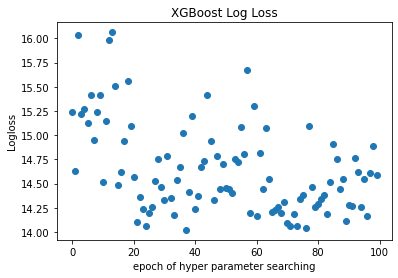

In [21]:
x = np.arange(100)
y = [x['loss'] for x in trials.results]
fig = plt.figure()
plt.scatter(x, y)
plt.xlabel("epoch of hyper parameter searching")
plt.ylabel("Logloss")
plt.title("XGBoost Log Loss")
fig.savefig("images/"+ stockname + "_search.png")
print("Best setting",xgb_opt)

In [22]:
best = {}
for para,value in xgb_opt.items():
    if para == 'max_depth' or para ==  'n_estimators':
        best[para] = int(value)
    else:
        best[para] = value

In [23]:
xgb = XGBClassifier(**best)
eval_set = [(tvec.transform(x_train), y_train), (tvec.transform(x_test), y_test)]
xgb.fit(tvec.transform(x_train), y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.009893997782568695, max_delta_step=0,
              max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=217, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8370043011977011, tree_method=None,
              validate_parameters=False, verbosity=None)

In [24]:
with open("models/" +  stockname + ".pickle" , 'wb') as f:
    pickle.dump(xgb, f)

In [25]:
pred = xgb.predict(tvec.transform(x_test))
print ('Optimal xgboost f1-score: %.4f' %metrics.f1_score(y_test,pred))
print ('Optimal xgboost accuracy: %.4f' %metrics. accuracy_score(y_test,pred))
con = metrics.confusion_matrix(y_test,pred)

Optimal xgboost f1-score: 0.6177
Optimal xgboost accuracy: 0.5940


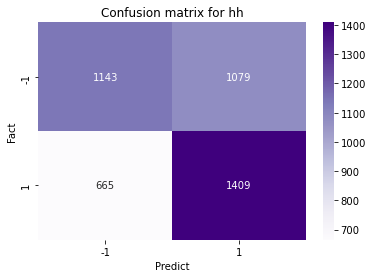

In [26]:
f, ax = plt.subplots(figsize = (6, 4))
sn.heatmap(con,annot=True,fmt ='g',cmap='Purples',xticklabels =['-1','1'], yticklabels=['-1','1'])
ax.set_title('Confusion matrix for '+stockname)
ax.set_xlabel('Predict')
ax.set_ylabel('Fact')
f.savefig("images/"+ stockname + "_con.png")

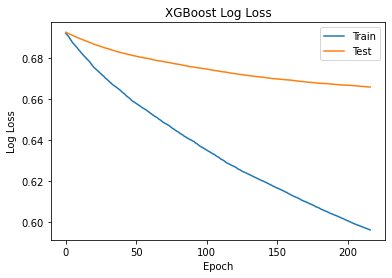

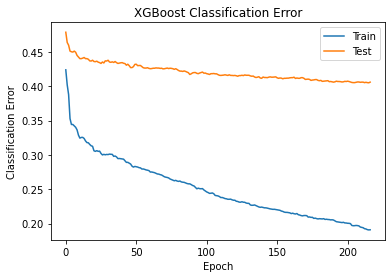

In [28]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
fig.savefig("images/"+ stockname + "_loss.png")
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
fig.savefig("images/"+ stockname + "_error.png")